# Evaluation of COVID model output

A formal writeup for this project can be found on my [personal website](https://hectorcarrion.com/home/vesta).

This notebook will generate scores for:

*   TP, TN, FP and FN
*   Accuracy
*   Prevalence
*   Sensitivity
*   Specificity
*   Positive Predictive Value
*   Negative Predictive Value
*   AUC
*   F1

We then display ROC and PRC curves as well as a confusion matrix heatmap.

Finally we identify some missclasified images and discuss why they may have been missed.

## Packages

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import eval_util as util
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    f1_score,
    confusion_matrix
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Experimental Results

As a reminder, our dataset contains X-rays from 3 different classes Normal, Pneumonia and COVID-19.

We have precomputed the model outputs for our data and saved them as `train_preds.txt`, `val_preds.txt` and `test_preds.txt`. We'll work with these predictions and the true class labels to perform the evaluations.

In [ ]:
train_results = pd.read_csv("train_preds.txt", delimiter = "\t")
val_results = pd.read_csv("val_preds.txt", delimiter = "\t")
test_results = pd.read_csv("test_preds.txt", delimiter = "\t")

Let's first confirm that we don't have any patient overlap across our 3 sets.

We should see three **False** outputs.

In [ ]:
print(util.check_for_leakage(train_results, val_results, 'PatientID'))
print(util.check_for_leakage(train_results, test_results, 'PatientID'))
print(util.check_for_leakage(test_results, val_results, 'PatientID'))

False
False
False


This evaluation will focus on the the **test set** but can be done for the others.

Let's visualize one pandas dataframe with all the information we need.

In [ ]:
class_labels = ['Normal',
                'Pneumonia',
                'Covid19']
pred_labels = [l + "_pred" for l in class_labels]

y = test_results[class_labels].values
pred = test_results[pred_labels].values
test_results[np.concatenate([class_labels, pred_labels])]

,Normal,Pneumonia,Covid19,Normal_pred,Pneumonia_pred,Covid19_pred
0,0,1,0,0.224807,0.157001,0.618193
1,0,1,0,0.000012,0.978799,0.021189
2,0,1,0,0.000020,0.979484,0.020495
3,0,1,0,0.000008,0.980587,0.019405
4,0,1,0,0.000046,0.967760,0.032195
...,...,...,...,...,...,...
145,0,1,0,0.001202,0.992656,0.006142
146,0,1,0,0.000316,0.998698,0.000986
147,0,1,0,0.000075,0.876681,0.123245
148,0,1,0,0.010469,0.553178,0.436353


Here we can see the ground truth values and the predicted values for each data point on our test data set.

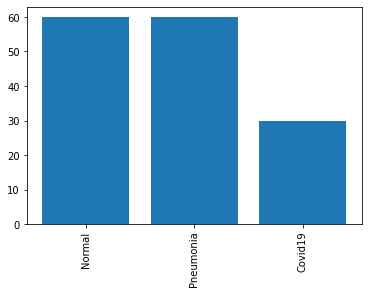

In [ ]:
plt.xticks(rotation=90)
plt.bar(x = class_labels, height= y.sum(axis=0));

We split our data to be 40% normal, 40% pneumonia and 20% Covid as discussed earlier.

Let's visualize our ROC curve:

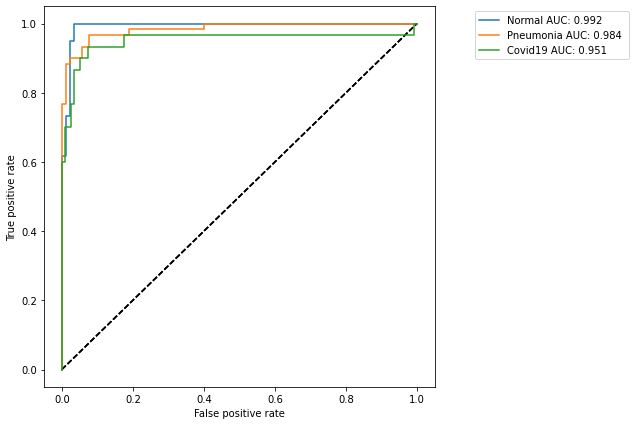

In [ ]:
util.get_curve(y, pred, class_labels)

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ideal point is at the top left, where the area under the curve is maximized.

This area is a measure of goodness of fit. Our high AUC summarizes the model output across all thresholds, and provides a good sense of the it's discriminative power.

Let's visualize our PRC curve:

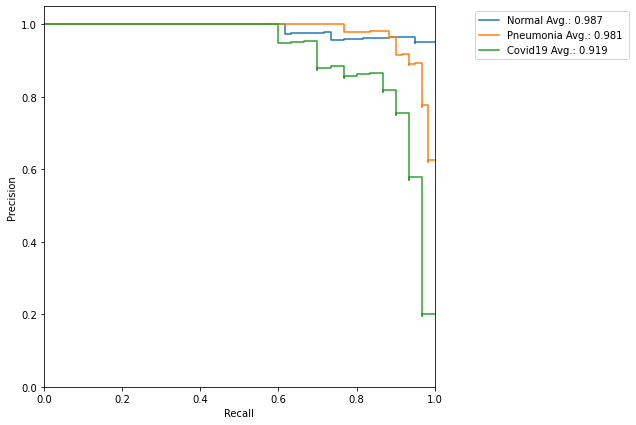

In [ ]:
util.get_curve(y, pred, class_labels, curve='prc')

Precision-Recall is a useful measure for good predictions when the classes are imbalanced. 

The precision-recall curve (PRC) shows the trade-off between precision and recall for different thresholds.

Our lower COVID-19 score is due to the fact that a lower recall score implies we are getting more False Negative predictions.

Let's get all our metrics:

In [ ]:
util.get_metrics_argmax(y, test_results, class_labels, pred_labels)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1
,,,,,,,,,,,,
Normal,59,87,3,1,0.973,0.4,0.983,0.967,0.952,0.989,0.975,0.967
Pneumonia,58,83,7,2,0.94,0.4,0.967,0.922,0.892,0.976,0.944,0.928
Covid19,22,119,1,8,0.94,0.2,0.733,0.992,0.957,0.937,0.862,0.83


We've scored very well on most metrics except for Sensitivity at 73%.

Sensitivity is the probability that our test outputs positive given that the case is actually positive. It's given by the following equation:

$$sensitivity = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Because we have a relatively high number of COVID False Negatives, this score suffered. This is a score we would like to see improve since we wouldn't want to miss too many COVID cases classifying them as Pneumonia instead.

On the flipside, it's good to see a high Specificity score, since that means a case that is not COVID likely won't be incorrectly classified as COVID.

Let's generate a confusion matrix and it's heatmap:

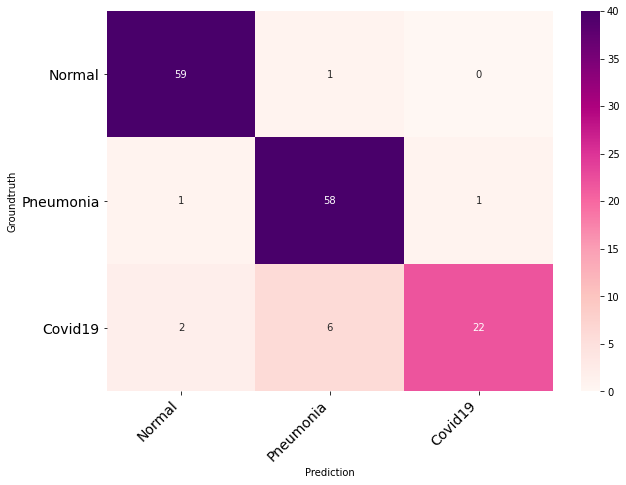

In [ ]:
cf_matrix = confusion_matrix(y.argmax(axis=1), pred.argmax(axis=1))
util.print_confusion_matrix(cf_matrix, class_names=class_labels, colors = 'RdPu')

The confusion matrix heatmap allows us how many predictions the model got correctly, as well as how it misclassified.

For example we can see that our largest error came from 6 COVID-19 cases misclassified as Pneumonia. Let's explore these images.

## Exploring incorrectly classified images

In [ ]:
is_covid = test_results['Covid19'] == 1
test_results_covid = test_results[is_covid]
test_results_covid

,PatientID,Image,Normal,Pneumonia,Covid19,Normal_pred,Pneumonia_pred,Covid19_pred
5,19,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,0,0,1,0.005779,0.287383,0.706838
6,19,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,0,0,1,0.000951,0.713516,0.285533
7,19,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,0,0,1,0.000423,0.729891,0.269686
8,19,1-s2.0-S0929664620300449-gr2_lrg-d.jpg,0,0,1,0.018064,0.136738,0.845198
9,36,8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg,0,0,1,0.727337,0.037806,0.234857
10,36,9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg,0,0,1,0.009926,0.076980,0.913094
11,42,1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg,0,0,1,0.110462,0.047268,0.842270
12,86,B2D20576-00B7-4519-A415-72DE29C90C34.jpeg,0,0,1,0.000133,0.072580,0.927287
13,86,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,0,0,1,0.001239,0.415281,0.583480
14,94,6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.ori...,0,0,1,0.892424,0.107249,0.000327


We can see that these are the missclasifications, and that some of them belong to the same patient.

In [ ]:
wrong_covid_images = {'Normal': ['8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg',
                                 '6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg'],
                      'Pneumonia': ['1-s2.0-S0929664620300449-gr2_lrg-b.jpg', # Patient 19
                                    '1-s2.0-S0929664620300449-gr2_lrg-c.jpg', # Patient 19
                                    'covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-3.jpg',
                                    'covid-19-pneumonia-43-day0.jpeg', # Patient 144
                                    'covid-19-pneumonia-43-day2.jpeg', # Patient 144
                                    'figure1-5e7c1b8d98c29ab001275405-98.jpeg']}

base_dir = '/content/drive/My Drive/PnH/Covid/dataset/data/'

Let's display the incorrect Pneumonia images.

COVID-19 classified as Pneumonia


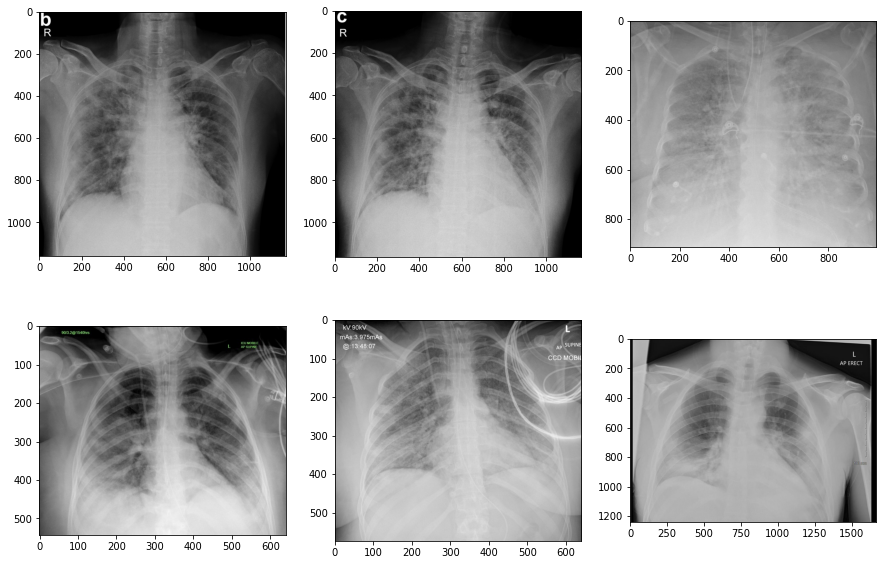

In [ ]:
nrows = 2
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, image in enumerate(wrong_covid_images['Pneumonia']):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)

  img = mpimg.imread(base_dir + image)
  plt.imshow(img)
print("COVID-19 classified as Pneumonia")
plt.show()

Let's compare to some actual pneumonia cases.

In [ ]:
actual_pneumonia = ['streptococcus-pneumoniae-pneumonia-1.jpg',
                    'pneumonia-7.jpg',
                    'pneumococcal-pneumonia-day7.jpg',
                    'parapneumonic-effusion-1-PA.png',
                    'right-upper-lobe-pneumonia-9-PA.jpg',
                    'klebsiella-pneumonia-1.jpg']

Ground truth Pneumonia cases


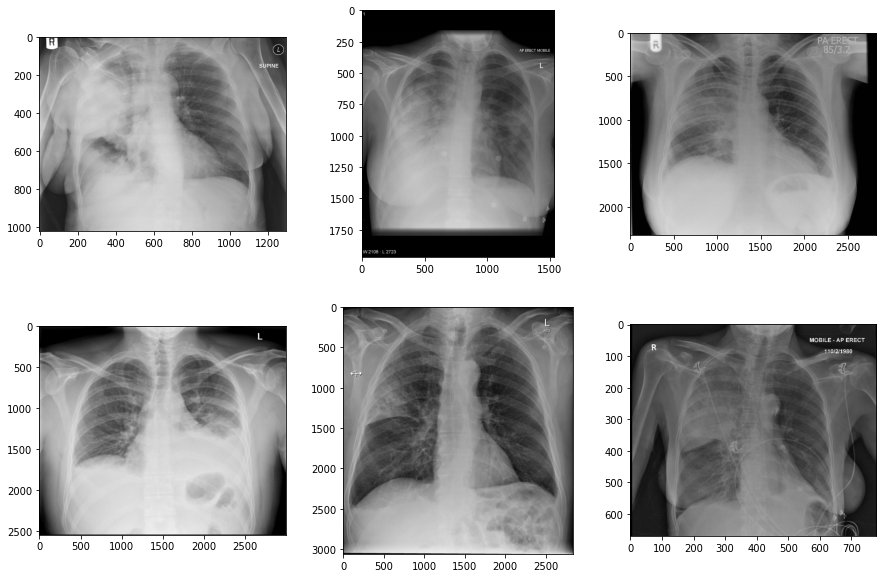

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, image in enumerate(actual_pneumonia):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)

  img = mpimg.imread(base_dir + image)
  plt.imshow(img)
print("Ground truth Pneumonia cases")
plt.show()

## Conclusion

After exploring these incorrect images I noticed a few things. The first two samples from left to right are of the same patient (ID 19) and so are the 4th and 5th (ID 144). The third sample is not very clear with most of its pixel values being very high. These could be factors as to why the model is classifying these images incorrectly.

We can also see that the actual Pneumonia casses look very similar to the untrained eye, this is likely why the model classified some COVID cases incorrectly. More training data could help further separate these two classes.